In [1]:
import os
from numpy import *
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt
# import seaborn as sns
import geopandas as gpd

# from rasterstats import zonal_stats
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob, os
# run for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import rtree
from shapely.geometry import shape, mapping, Point, LinearRing

### Folder Structure

In [3]:
#%% Read in data
rice_root = '/home/apoorval/Research/GeoSpatial/India_Forests/'
dbox_root = '/home/alal/res/India_Forests/'
# saad_root = '~/Dropbox/india_forests/'
# root = dbox_root 
root = Path(dbox_root)
code = root / 'Code'
data = root / 'Data'
spatial = data / 'Spatial'

In [4]:
%cd $spatial

/home/alal/Dropbox/1_Research/India_Forests/Data/Spatial


# Read Village level files 

In [5]:
vil_1 = gpd.read_file("Processed/village_stack_deforestation.gpkg")
vil_2 = gpd.read_file("Processed/village_stack_ex_ante.gpkg")

In [6]:
vil_1.shape
vil_2.shape

(308503, 124)

(308503, 109)

In [7]:
[x for x in vil_1.columns]

['ANDHR_ID',
 'CHHAT_ID',
 'CODE_2011',
 'DISTRICT',
 'F_AGLB',
 'F_CULT',
 'F_ILLT',
 'F_L6',
 'F_LIT',
 'F_MAG_0_3',
 'F_MAG_3_6',
 'F_MFHH',
 'F_MHH_0_3',
 'F_MHH_3_6',
 'F_MNW',
 'F_MOT_0_3',
 'F_MOT_3_6',
 'F_MRG_0_3',
 'F_MRG_3_6',
 'F_MRG_AGLB',
 'F_MRG_CULT',
 'F_MRG_HH',
 'F_MRG_OTH',
 'F_MRW',
 'F_M_CL_0_3',
 'F_M_CL_3_6',
 'F_NNW',
 'F_OTH_W',
 'F_POP',
 'F_SC',
 'F_ST',
 'F_W',
 'GUJAR_ID',
 'HP_ID',
 'JHAR_ID',
 'LEVEL',
 'MADHYA_ID',
 'MAHARA_ID',
 'M_AGLB',
 'M_CULT',
 'M_ILLT',
 'M_L6',
 'M_LIT',
 'M_MAG_0_3',
 'M_MAG_3_6',
 'M_MFHH',
 'M_MHH_0_3',
 'M_MHH_3_6',
 'M_MNW',
 'M_MOT_0_3',
 'M_MOT_3_6',
 'M_MRG_0_3',
 'M_MRG_3_6',
 'M_MRG_AGLB',
 'M_MRG_CULT',
 'M_MRG_HH',
 'M_MRG_OTH',
 'M_MRW',
 'M_M_CL_0_3',
 'M_M_CL_3_6',
 'M_NNW',
 'M_OTH_W',
 'M_POP',
 'M_SC',
 'M_ST',
 'M_W',
 'NAME',
 'ODISHA_ID',
 'RAJAS_ID',
 'STATE_UT',
 'SUB_DIST',
 'TOT_AGLB',
 'TOT_CULT',
 'TOT_HH',
 'TOT_ILLT',
 'TOT_L6',
 'TOT_LIT',
 'TOT_MNW',
 'TOT_MRW',
 'TOT_NNW',
 'TOT_OTH_W',
 'TOT_POP

In [12]:
[x for x in vil_1.columns if x not in vil_2.columns]
ea_cols = [x for x in vil_2.columns if x not in vil_1.columns]

['deforest_0',
 'deforest_count',
 'deforest_1',
 'deforest_4',
 'deforest_6',
 'deforest_8',
 'deforest_10',
 'deforest_5',
 'deforest_11',
 'deforest_9',
 'deforest_12',
 'deforest_3',
 'deforest_7',
 'deforest_2',
 'deforest_14',
 'deforest_17',
 'deforest_13',
 'deforest_15',
 'deforest_16']

In [13]:
ea_cols

['preF_min', 'preF_max', 'preF_mean', 'preF_count']

### Regular merge on index  

In [14]:
vil = pd.merge(vil_1, vil_2.loc[:, ea_cols], right_index = True, left_index = True)

In [15]:
vil.columns

Index(['ANDHR_ID', 'CHHAT_ID', 'CODE_2011', 'DISTRICT', 'F_AGLB', 'F_CULT',
       'F_ILLT', 'F_L6', 'F_LIT', 'F_MAG_0_3',
       ...
       'deforest_14', 'deforest_17', 'deforest_13', 'deforest_15',
       'deforest_16', 'geometry', 'preF_min', 'preF_max', 'preF_mean',
       'preF_count'],
      dtype='object', length=128)

# Create villages dataset with centroids and distance to relevant border

Steps to construct border

+ read in `BLOCKS_sch_coded.geojson`
+ filter by `sch == 1`
+ Vector Tools > Dissolve
+ Temporary Layer > Vector Tools > Polygons to line

In [19]:
border= gpd.read_file('Processed/boundary.geojson')

## Centroids 

In [20]:
vil['centroid'] = vil.centroid
vil["x"] = vil.centroid.map(lambda p: p.x)
vil["y"] = vil.centroid.map(lambda p: p.y)
vil = vil.set_geometry('centroid')
vil.drop(['geometry'], inplace = True, axis=1)

In [22]:
vil.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 308503 entries, 0 to 308502
Columns: 130 entries, ANDHR_ID to y
dtypes: float64(116), geometry(1), int64(5), object(8)
memory usage: 306.0+ MB


## Nearest segment of border 

In [25]:
index = rtree.index.Index()
for ind, row in border.iterrows():
    geom1 = shape(row['geometry'])
    index.insert(ind, geom1.bounds)

In [26]:
nearest_segment     = lambda x: list(index.nearest(x.bounds, 1))[0]
distance_to_nearest = lambda x: border.distance(x).min()

In [27]:
%%time
vil['min_dist_to_border'] = vil.geometry.apply(distance_to_nearest)
vil['nearest_segment'] = vil.geometry.apply(nearest_segment)

CPU times: user 3min 52s, sys: 172 ms, total: 3min 52s
Wall time: 3min 54s


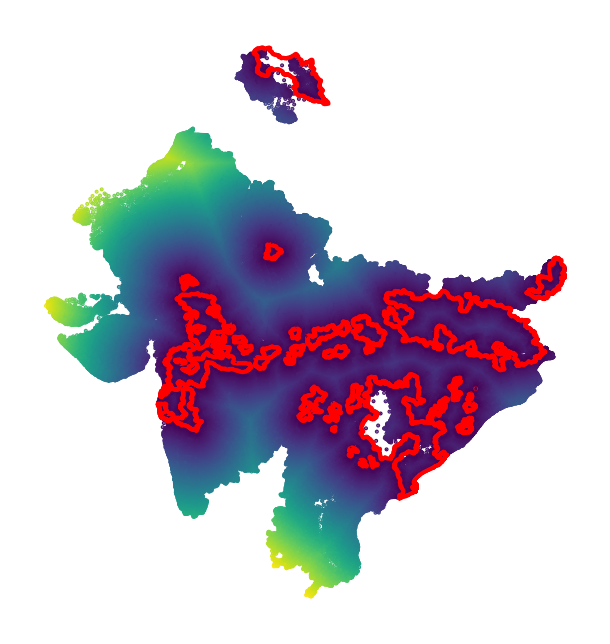

In [28]:
#%% plot minimum distance
f, ax = plt.subplots(1,dpi=200)
vil.plot(column='min_dist_to_border', cmap='viridis',
    markersize=0.2,ax=ax)
border.plot(edgecolor='red', ax=ax)
ax.set_axis_off()

In [29]:
vil.rename(columns = {'x': 'lon', 'y': 'lat'}, inplace = True)

In [30]:
vil.shape

(308503, 132)

In [32]:
%%time 
vil.to_file(spatial/'Processed/all_villages_data.gpkg', driver='GPKG')

CPU times: user 21min 47s, sys: 13.2 s, total: 22min
Wall time: 22min 9s


## write csv for prelim analysis 

In [33]:
vil.columns

Index(['ANDHR_ID', 'CHHAT_ID', 'CODE_2011', 'DISTRICT', 'F_AGLB', 'F_CULT',
       'F_ILLT', 'F_L6', 'F_LIT', 'F_MAG_0_3',
       ...
       'deforest_16', 'preF_min', 'preF_max', 'preF_mean', 'preF_count',
       'centroid', 'lon', 'lat', 'min_dist_to_border', 'nearest_segment'],
      dtype='object', length=132)

In [35]:
df = pd.DataFrame(vil.drop(columns=['centroid']))

In [37]:
df.to_csv(data / 'Intermediate/villages_points_all2.csv')